In [1]:
import word2vec as w2v
import pandas as pd
# import cupy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow import keras


ModuleNotFoundError: No module named 'pandas'

In [8]:
tf.debugging.set_log_device_placement(True)
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.4.1
Num GPUs Available:  1


In [5]:
trumpTweets_DF = pd.read_csv("realdonaldtrump.csv", sep=",")
tweetsContent = trumpTweets_DF["content"].to_numpy()
model = w2v.Word2Vec()
model.loadFromFile("testing1.txt")

result_data = w2v.Word2Vec()
result_data.loadFromFile("result.txt")
result = result_data.words_df
print(1- cosine(model.words_df.loc[result["word"].isin(["donald"])]["vector"].values[0], model.words_df.loc[result["word"].isin(["trump"])]["vector"].values[0]))
print(1- cosine(result.loc[result["word"].isin(["donald"])]["vector"].values[0], result.loc[result["word"].isin(["trump"])]["vector"].values[0]))

-0.10681179215145686
0.5981076985835707


In [6]:
list_of_tweets = w2v.stripPunctuation(tweetsContent[:100])
list_of_tweets_as_vec = [np.vstack(result.loc[result.word.isin(tweet)].vector.values) for tweet in list_of_tweets]
longest_tweet = 0
for tweet in list_of_tweets_as_vec :
	if tweet.shape[0] > longest_tweet :
		longest_tweet = tweet.shape[0]
for i, tweet in enumerate(list_of_tweets_as_vec) :
	list_of_tweets_as_vec[i] = np.pad(tweet, [(0, longest_tweet - tweet.shape[0]), (0,0)])
list_of_tweets_as_vec = np.array(list_of_tweets_as_vec)

n_sampl, n_x, n_y = list_of_tweets_as_vec.shape
d2_list_of_tweets = list_of_tweets_as_vec.reshape((n_sampl,n_x*n_y))

wordX_train, wordX_test, retweet_y_train, retweet_y_test = train_test_split(d2_list_of_tweets, trumpTweets_DF.retweets[:100], test_size=0.2)

retweet_models = []


In [ ]:
retweets_model = keras.Sequential()
normalizer = tf.keras.layers.Normalization(axis=-1)

In [5]:
retweets_model = keras.Sequential()
retweets_model.add(keras.layers.Dense(100, activation="relu"))
retweets_model.add(keras.layers.Dense(200))
retweets_model.add(keras.layers.Dense(100))
retweets_model.add(keras.layers.Dense(50))
retweets_model.compile(loss="mse", optimizer="sgd")
retweets_model.summary()

: 

: 

IndexError: list index out of range

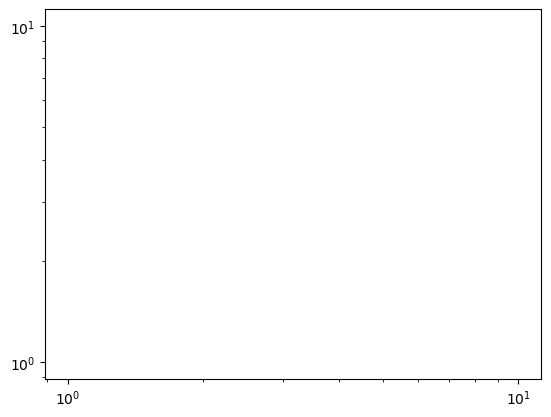

In [5]:
plt.yscale('log')
plt.xscale('log')
plt.plot(retweet_models[0].predict(wordX_test), 'o', label="predicted")
plt.plot(retweet_y_test, 'o', label="real")
plt.legend()